<a href="https://colab.research.google.com/github/KU-Gen-AI-2567/VAE-demo/blob/main/VAE_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VAE - 01418496

**สมาชิกกลุ่ม**

นายศิวกร ภาสว่าง 6410451423

นางสาว เเพรวรุ้ง พุดชะวา 6410451253

นางสาว มารีน่า มิทซุย 6410450222

หมู่ 200

ชุดข้อมูล : Smiling or Not | Face Data

link download : https://www.kaggle.com/datasets/chazzer/smiling-or-not-face-data

In [136]:
import tensorflow as tf
import matplotlib.pyplot as plt
import kagglehub
import shutil
import os
import numpy as np
from PIL import Image
tf.__version__

'2.18.0'

## Setting to execute on Processor (GPU or CPU)

In [137]:
gpus = tf.config.list_physical_devices("GPU")
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("Execute on GPU")
else:
    print("Execute on CPU")

Execute on CPU


## Download Dataset

In [138]:
# Download the dataset folder in latest version
if not "dataset" in os.listdir("."):
    path = kagglehub.dataset_download("chazzer/smiling-or-not-face-data")
    print("Path to dataset files:", path)
    shutil.move(path, "./dataset")
    print("Download Dataset Complete")
else:
    print("Download Dataset Already")

Download Dataset Already


## Prepossessing

In [139]:
from tensorflow.keras import utils
import cv2 as cv

IMAGE_SIZE = (64, 64) 
BATCH_SIZE = 128

# train_data = utils.image_dataset_from_directory(
#     "dataset/images",
#     labels=None,
#     color_mode="rgb", # 🤔
#     image_size=IMAGE_SIZE,
#     batch_size=BATCH_SIZE,
#     shuffle=True,
#     seed=42,
#     interpolation="bilinear",
# )

# def preprocess(img):
#     img = tf.cast(img, "float32") / 255.0 # 🤔
#     return img

# train_data = train_data.map(lambda x: preprocess(x))

def shuffle_images(images, seed=100):
    np.random.seed(seed)
    np.random.shuffle(images)

path = "./dataset"
class_names = os.listdir(path)[:-1] # ['non_smile', 'smile']
train_image = []
train_label = []
for class_name in enumerate(class_names):
    sub_path = f"{path}/{class_name[1]}"
    filenames = os.listdir(sub_path) # * Read filename in each dir 📁
    for filename in filenames:
        
        # * Preprocess 📄
        sub_sub_path = f"{path}/{class_name[1]}/{filename}"
        image = cv.imread(sub_sub_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        image = cv.resize(image, IMAGE_SIZE)
        image = tf.cast(image, "float32") / 255.0
        train_image.append(image)
        train_label.append(class_name[0])

train_image = np.array(train_image)
shuffle_images(train_image)
train_label = np.array(train_label)
shuffle_images(train_label)

print(f"Shape of train_data: {train_image.shape}")
print(f"Shape of train_label: {train_label.shape}")
print(f"Classnames : {class_names}")


Shape of train_data: (1203, 64, 64, 3)
Shape of train_label: (1203,)
Classnames : ['non_smile', 'smile']


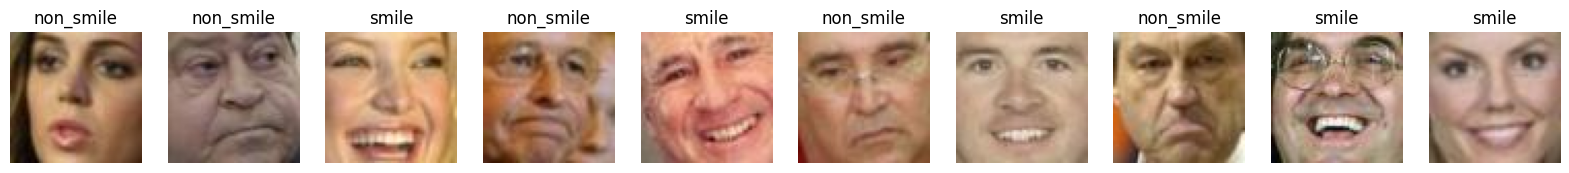

In [140]:
import matplotlib.pyplot as plt

def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    batch = batch[0] if isinstance(batch, tuple) else batch
    return batch.numpy()

def display(images, labels, n=10, size=(20, 3), cmap="gray_r", as_type="float32"):
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)

    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.title(class_names[labels[i]])
        plt.axis("off")

    plt.show()

# train_sample = sample_batch(train_image)
display(train_image, train_label, cmap=None)

## Create Model

In [141]:
# code for creating model
from tensorflow.keras import layers, activations, models
import tensorflow.keras.backend as K

Z_DIM = 200

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5*z_log_var) * epsilon

encoder_input = layers.Input(shape=(64, 64, 3), name="EncoderInput")
x = layers.Conv2D(256, (2, 2), activation=activations.leaky_relu, padding="same", strides=2)(encoder_input)
x = layers.Conv2D(128, (2, 2), activation=activations.leaky_relu, padding="same", strides=2)(x)
x = layers.Conv2D(64, (2, 2), activation=activations.leaky_relu, padding="same", strides=2)(x)

shape_before_flatten = K.int_shape(x)[1:]

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])

encoder_model = models.Model(encoder_input, [z_mean, z_log_var, z], name="EncoderModel")
encoder_model.summary()

Model: "EncoderModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ EncoderInput        │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │      3,328 │ EncoderInput[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 16, 16,    │    131,200 │ conv2d_44[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 8, 8, 64)  │     32,832 │ conv2d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_11          │ (None, 4096)      │          0 │ conv2d_46[0][0]   │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 200)       │    819,400 │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 200)       │    819,400 │ flatten_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_11         │ (None, 200)       │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,806,160 (6.89 MB)

 Trainable params: 1,806,160 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

In [142]:
decoder_input = layers.Input(shape=(Z_DIM, ), name='Decoder Input')
x = layers.Dense(tf.math.reduce_prod(shape_before_flatten).numpy())(decoder_input)
x = layers.Reshape(shape_before_flatten)(x)
x = layers.Conv2DTranspose(64, (2, 2), activation=activations.leaky_relu, padding='same', strides=2)(x)
x = layers.Conv2DTranspose(128, (2, 2), activation=activations.leaky_relu, padding='same', strides=2)(x)
x = layers.Conv2DTranspose(256, (2, 2), activation=activations.leaky_relu, padding='same', strides=2)(x)
decoder_output = layers.Conv2D(3, (2, 2), activation=activations.sigmoid, padding='same')(x)

decoder_model = models.Model(decoder_input, decoder_output, name="DecoderModel")
decoder_model.summary()

Model: "DecoderModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Decoder Input (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4096)           │       823,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_10 (Reshape)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_30             │ (None, 16, 16, 64)     │        16,448 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_31             │ (None, 32, 32, 128)    │        32,896 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_32             │ (None, 64, 64, 256)    │       131,328 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 64, 64, 3)      │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,007,043 (3.84 MB)

 Trainable params: 1,007,043 (3.84 MB)

 Non-trainable params: 0 (0.00 B)

In [143]:
from tensorflow.keras import metrics, losses, optimizers

BETA = 500

class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(BETA * losses.MSE(data, reconstruction))
            kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(BETA * losses.MSE(data, reconstruction))
        kl_loss = tf.reduce_mean(tf.reduce_sum(-0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), axis=1))
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

vae = VAE(encoder_model, decoder_model)
vae.compile(optimizer=optimizers.AdamW(learning_rate=0.0001))

## Train Model

In [144]:
# code for training model
from tensorflow.keras import callbacks

EPOCHS = 20

class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range(self.num_img):
            utils.array_to_img(generated_images[i])

vae.fit(
    train_image,
    epochs=EPOCHS,
    callbacks=[ImageGenerator(num_img=10, latent_dim=Z_DIM)],
    batch_size = 32
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 314ms/step - kl_loss: 0.1418 - loss: 21.3502 - reconstruction_loss: 21.2084
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 293ms/step - kl_loss: 0.0046 - loss: 17.8486 - reconstruction_loss: 17.8440
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 297ms/step - kl_loss: 0.0029 - loss: 15.9441 - reconstruction_loss: 15.9412
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 302ms/step - kl_loss: 0.0039 - loss: 15.8340 - reconstruction_loss: 15.8301
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 305ms/step - kl_loss: 0.0049 - loss: 15.8251 - reconstruction_loss: 15.8202
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 309ms/step - kl_loss: 0.0049 - loss: 16.0751 - reconstruction_loss: 16.0703
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 313ms/step - kl_loss: 0.0051 - loss: 16.0766 - reconstruction_loss: 16.0716
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 304ms/step - kl_loss: 0.0051 - loss: 16.4756 - reconstruction_loss: 16.4705
Epoch 9/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 12s 305ms/step - k

## Visulization

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Examples


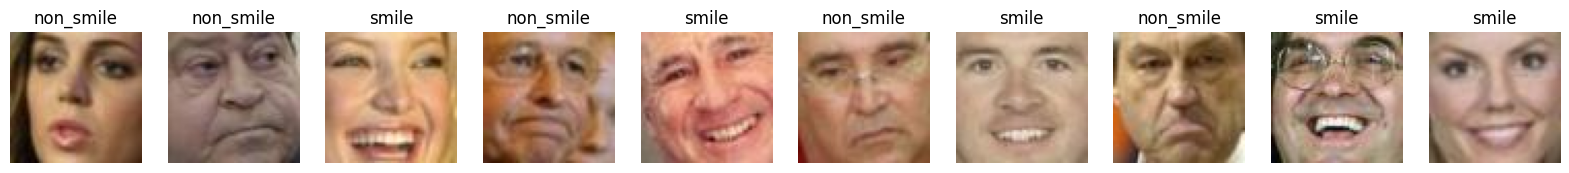

Reconstructions


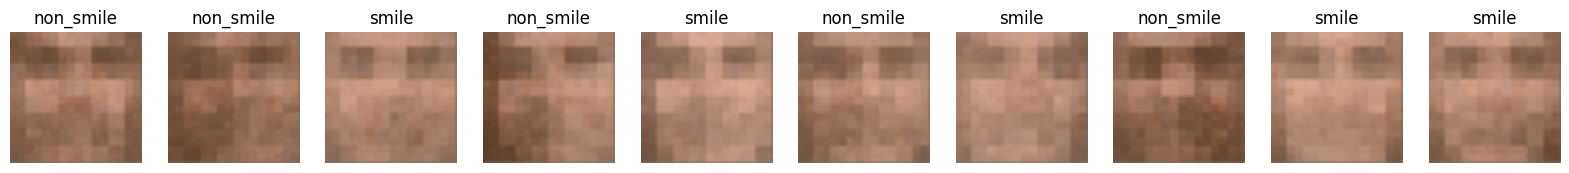

In [145]:
# code for visulization 1
batches_to_predict = 1
example_images = train_image[:20]
z_mean, z_log_var, reconstructions = vae.predict(example_images)

print("Examples")
display(example_images, labels=train_label[:20])

print("Reconstructions")
display(reconstructions, labels=train_label[:20])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


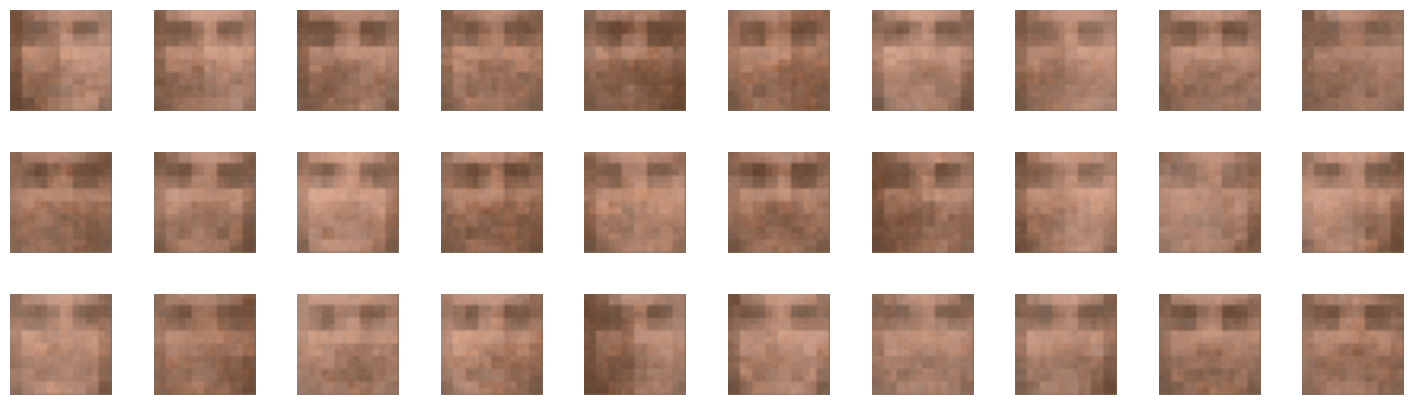

In [146]:
# code for visulization 2
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))
reconstructions = decoder_model.predict(z_sample)
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])


## Member Participation

รายละเอียดการมีส่วนร่วม